# DataSet

### Importing Packages

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Importing Clean DBs

In [56]:
History_df_Clean = pd.read_csv('Clean_History_Data.csv')
Activity_df_Clean = pd.read_csv('Clean_Activity_Data.csv')
Clean_Customer_Timeline = pd.read_csv('Clean_Customer_Timeline.csv')

# KPI - Average Tenure of Enrollment

In [57]:
import pandas as pd
import numpy as np

# Define fixed cutoff date
cutoff_date = pd.Timestamp('2018-12-01')

# Calculate customer tenure in months if not already present
if 'Tenure_Months' not in History_df_Clean.columns:

    # Ensure date columns are datetime
    History_df_Clean['Enrollment Date'] = pd.to_datetime(History_df_Clean['Enrollment Date'], errors='coerce')
    History_df_Clean['Cancellation Date'] = pd.to_datetime(History_df_Clean['Cancellation Date'], errors='coerce')

    # For active customers (no cancellation), use the cutoff date instead
    calc_cancel_date = History_df_Clean['Cancellation Date'].fillna(cutoff_date)

    # Compute full tenure in months (ceil always rounds up)
    History_df_Clean['Tenure_Months'] = np.ceil(
        (calc_cancel_date - History_df_Clean['Enrollment Date']).dt.days / 30
    ).astype('Int64')

History_df_Clean

,Loyalty Number,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,Tenure_Months
0,480934,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN,2016-02-01,NaT,35
1,549612,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN,2016-03-01,NaT,34
2,429460,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0,2014-07-01,2018-01-01,43
3,608370,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN,2013-02-01,NaT,71
4,530508,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN,2014-10-01,NaT,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16732,823768,British Columbia,Vancouver,V6E 3Z3,Female,College,NaN,Married,Star,61850.19,Standard,2012,12,NaN,NaN,2012-12-01,NaT,74
16733,680886,Saskatchewan,Regina,S1J 3C5,Female,Bachelor,89210.0,Married,Star,67907.27,Standard,2014,9,NaN,NaN,2014-09-01,NaT,52
16734,776187,British Columbia,Vancouver,V5R 1W3,Male,College,NaN,Single,Star,74228.52,Standard,2014,3,NaN,NaN,2014-03-01,NaT,58
16735,906428,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,0.0,Married,Star,10018.66,2018 Promotion,2018,4,NaN,NaN,2018-04-01,NaT,9


In [58]:
def tenure_by_category(category_col):
    """
    Compare customer tenure (in months) across any categorical variable.
    category_col: column name in History_df_Clean (string)
    """

    df = History_df_Clean.copy()

    # Ensure tenure exists in months
    df['Tenure_Months'] = np.ceil(
        (df['Cancellation Date'] - df['Enrollment Date']).dt.days / 30
    )

    # Create cancellation flag if missing
    if 'Cancelled' not in df.columns:
        df['Cancelled'] = df['Cancellation Date'].notna()

    result = (
        df.groupby(category_col)
        .agg(
            Customers=('Loyalty Number', 'count'),
            Cancelled=('Cancelled', 'sum'),
            Avg_Tenure_Months=('Tenure_Months', 'mean'),   # moved up
            Cancellation_Rate=('Cancelled', 'mean'),
            Median_Tenure_Months=('Tenure_Months', 'median'),
            Min_Tenure_Months=('Tenure_Months', 'min'),
            Max_Tenure_Months=('Tenure_Months', 'max')
        )
        .reset_index()
    )

    # Convert churn rate → percentage
    result['Cancellation_Rate'] = (result['Cancellation_Rate'] * 100).round(2)

    # Round all numeric values
    result = result.round(2)

    # Sort by Avg_Tenure_Months descending
    result = result.sort_values(by='Avg_Tenure_Months', ascending=False)

    return result


In [59]:
tenure_by_category('Enrollment Type')

,Enrollment Type,Customers,Cancelled,Avg_Tenure_Months,Cancellation_Rate,Median_Tenure_Months,Min_Tenure_Months,Max_Tenure_Months
1,Standard,15766,1952,17.36,12.38,9.0,0.0,72.0
0,2018 Promotion,971,115,8.53,11.84,9.0,1.0,10.0


In [60]:
def tenure_by_category_with_enrollment_type(category_col):
    """
    Compare customer tenure in months across any category,
    split by Enrollment Type (Standard vs 2018 Promotion).
    """

    df = History_df_Clean.copy()

    # Compute tenure in months (rounded up)
    df['Tenure_Months'] = np.ceil(
        (df['Cancellation Date'] - df['Enrollment Date']).dt.days / 30
    )

    # Cancellation flag
    if 'Cancelled' not in df.columns:
        df['Cancelled'] = df['Cancellation Date'].notna()

    # Group by category + enrollment type
    result = (
        df.groupby([category_col, 'Enrollment Type'])
        .agg(
            Customers=('Loyalty Number', 'count'),
            Cancelled=('Cancelled', 'sum'),
            Avg_Tenure_Months=('Tenure_Months', 'mean'),
            Cancellation_Rate=('Cancelled', 'mean'),
            Median_Tenure_Months=('Tenure_Months', 'median'),
            Min_Tenure_Months=('Tenure_Months', 'min'),
            Max_Tenure_Months=('Tenure_Months', 'max')
        )
        .reset_index()
    )

    # Convert churn rate to %
    result['Cancellation_Rate'] = (result['Cancellation_Rate'] * 100).round(2)

    # Round all numeric columns
    result = result.round(2)

    return result


In [61]:
tenure_by_category_with_enrollment_type('Loyalty Card')


,Loyalty Card,Enrollment Type,Customers,Cancelled,Avg_Tenure_Months,Cancellation_Rate,Median_Tenure_Months,Min_Tenure_Months,Max_Tenure_Months
0,Aurora,2018 Promotion,208,29,8.59,13.94,9.0,2.0,10.0
1,Aurora,Standard,3221,420,16.51,13.04,9.0,0.0,66.0
2,Nova,2018 Promotion,330,38,8.63,11.52,9.0,2.0,10.0
3,Nova,Standard,5341,679,17.56,12.71,9.0,0.0,71.0
4,Star,2018 Promotion,433,48,8.42,11.09,9.0,1.0,10.0
5,Star,Standard,7204,853,17.61,11.84,9.0,0.0,72.0


In [80]:
# --- MONTHLY FLIGHTS ---
monthly_flights = (
    Activity_df_Clean.groupby('Date')['Total Flights']
    .sum()
    .reset_index()
)

# --- MONTHLY ENROLLMENTS ---
# Ensure Enroll_YearMonth as datetime (no time component)
History_df_Clean['Enroll_YearMonth'] = (
    pd.to_datetime(History_df_Clean['Enrollment Date']).dt.to_period('M').dt.to_timestamp()
)

monthly_enrollments = (
    History_df_Clean.groupby('Enroll_YearMonth')['Loyalty Number']
    .count()
    .reset_index(name='Enrollments')
)

# --- MONTHLY AVERAGE CLV ---
clv_time = (
    History_df_Clean.groupby('Enroll_YearMonth')['CLV']
    .mean()
    .reset_index(name='Avg_CLV')
)

# --- Ensure consistent types for merging ---
monthly_flights['Date'] = pd.to_datetime(monthly_flights['Date']).dt.to_period('M').dt.to_timestamp()
monthly_enrollments['Enroll_YearMonth'] = pd.to_datetime(monthly_enrollments['Enroll_YearMonth']).dt.to_period('M').dt.to_timestamp()
clv_time['Enroll_YearMonth'] = pd.to_datetime(clv_time['Enroll_YearMonth']).dt.to_period('M').dt.to_timestamp()

# --- MERGE ALL ---
monthly_kpis = (
    monthly_flights
    .merge(monthly_enrollments, left_on='Date', right_on='Enroll_YearMonth', how='left')
    .merge(clv_time, left_on='Date', right_on='Enroll_YearMonth', how='left')
    [['Date', 'Total Flights', 'Enrollments', 'Avg_CLV']]
)

monthly_kpis.fillna(0, inplace=True)


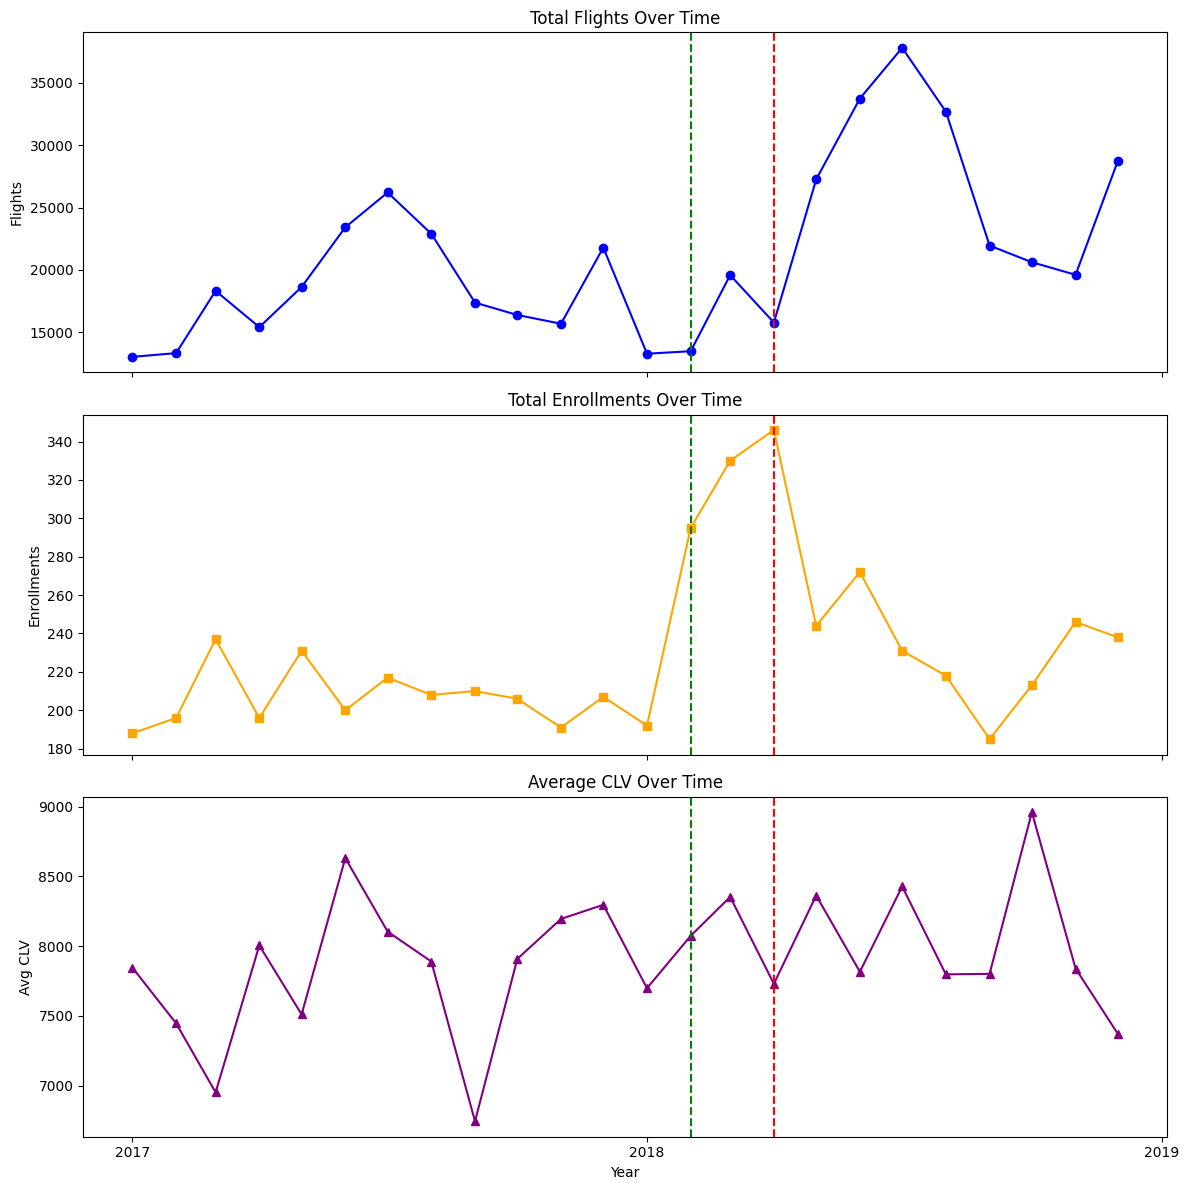

In [85]:
# Ensure timeline is sorted
monthly_kpis = monthly_kpis.sort_values('Date')

# Promotion markers
promo_start = pd.to_datetime('2018-02-01')
promo_end   = pd.to_datetime('2018-04-01')

# ---------------------------
#   CREATE SUBPLOTS
# ---------------------------
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# ===========================
# 1️⃣  TOTAL FLIGHTS
# ===========================

axes[0].plot(monthly_kpis['Date'], monthly_kpis['Total Flights'], 
             color='blue', marker='o')
axes[0].set_title("Total Flights Over Time")
axes[0].set_ylabel("Flights")

# promo window
axes[0].axvline(promo_start, color='green', linestyle='--')
axes[0].axvline(promo_end,   color='red', linestyle='--')


# ===========================
# 2️⃣  TOTAL ENROLLMENTS
# ===========================

axes[1].plot(monthly_kpis['Date'], monthly_kpis['Enrollments'], 
             color='orange', marker='s')
axes[1].set_title("Total Enrollments Over Time")
axes[1].set_ylabel("Enrollments")

# promo window
axes[1].axvline(promo_start, color='green', linestyle='--')
axes[1].axvline(promo_end,   color='red', linestyle='--')


# ===========================
# 3️⃣  AVERAGE CLV
# ===========================

axes[2].plot(monthly_kpis['Date'], monthly_kpis['Avg_CLV'], 
             color='purple', marker='^')
axes[2].set_title("Average CLV Over Time")
axes[2].set_ylabel("Avg CLV")
axes[2].set_xlabel("Year")

# promo window
axes[2].axvline(promo_start, color='green', linestyle='--')
axes[2].axvline(promo_end,   color='red', linestyle='--')


# ===========================
#  SHARED X-AXIS FORMATTING
# ===========================

axes[2].xaxis.set_major_locator(mdates.YearLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


# Preliminary Data Research
###### (Irrelevant for Merged Project)

### Statistics

In [62]:
History_df_Clean.describe(include='all').round(2)

,Loyalty Number,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,Tenure_Months
count,16737.00,16737,16737,16737,16737,16737,12499.00,16737,16737,16737.00,16737,16737.00,16737.00,2067.00,2067.00,16737,2067,16737.0
unique,NaN,11,29,55,2,5,NaN,3,3,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
top,NaN,Ontario,Toronto,V6E 3D9,Female,Bachelor,NaN,Married,Star,NaN,Standard,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
freq,NaN,5404,3351,911,8410,10475,NaN,9735,7637,NaN,15766,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
mean,549735.88,NaN,NaN,NaN,NaN,NaN,79302.48,NaN,NaN,7988.90,NaN,2015.25,6.67,2016.50,6.96,2015-09-22 11:45:55.977773824,2016-12-30 23:07:03.222060800,36.53
min,100018.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,1898.01,NaN,2012.00,1.00,2013.00,1.00,2012-04-01 00:00:00,2013-01-01 00:00:00,0.0
25%,326603.00,NaN,NaN,NaN,NaN,NaN,59246.50,NaN,NaN,3980.84,NaN,2014.00,4.00,2016.00,4.00,2014-01-01 00:00:00,2016-01-01 00:00:00,12.0
50%,550434.00,NaN,NaN,NaN,NaN,NaN,73455.00,NaN,NaN,5780.18,NaN,2015.00,7.00,2017.00,7.00,2015-11-01 00:00:00,2017-04-01 00:00:00,34.0
75%,772019.00,NaN,NaN,NaN,NaN,NaN,88517.50,NaN,NaN,8940.58,NaN,2017.00,10.00,2018.00,10.00,2017-07-01 00:00:00,2018-03-01 00:00:00,58.0
max,999986.00,NaN,NaN,NaN,NaN,NaN,407228.00,NaN,NaN,83325.38,NaN,2018.00,12.00,2018.00,12.00,2018-12-01 00:00:00,2018-12-01 00:00:00,82.0


In [63]:
Activity_df_Clean.describe(include='all').round(2)

,Loyalty Number,Year,Month,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Date
count,389041.00,389041.00,389041.00,389041.00,389041.00,389041.00,389041.00,389041.00,389041
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-01
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16736
mean,550229.59,2017.51,6.51,1.30,1954.42,2040.91,31.44,5.66,NaN
std,258571.84,0.50,3.45,1.97,3249.69,3885.47,126.92,22.85,NaN
min,100018.00,2017.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN
25%,327470.00,2017.00,4.00,0.00,0.00,0.00,0.00,0.00,NaN
50%,551429.00,2018.00,7.00,0.00,0.00,0.00,0.00,0.00,NaN
75%,772019.00,2018.00,10.00,2.00,3048.00,3069.00,0.00,0.00,NaN


### Correlation Matrix

In [64]:
Merged_df = Activity_df_Clean.merge(History_df_Clean, on='Loyalty Number', how='left')
corr_matrix = Merged_df.select_dtypes(include=['int64','float64']).corr().round(2)
corr_matrix

,Loyalty Number,Year,Month,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Salary,CLV,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Tenure_Months
Loyalty Number,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.01,-0.00,0.01,0.00,0.01,0.04,-0.01
Year,-0.00,1.00,0.00,0.06,0.06,0.07,0.01,0.01,-0.01,0.00,0.04,-0.03,0.03,0.03,-0.03
Month,-0.00,0.00,1.00,0.08,0.07,0.06,0.02,0.02,-0.00,0.00,0.01,-0.00,0.00,0.00,-0.00
Total Flights,-0.00,0.06,0.08,1.00,0.91,0.89,0.15,0.15,-0.01,-0.00,-0.05,-0.08,0.27,0.10,0.13
Distance,-0.00,0.06,0.07,0.91,1.00,0.98,0.14,0.14,-0.01,-0.00,-0.05,-0.07,0.25,0.10,0.12
Points Accumulated,-0.00,0.07,0.06,0.89,0.98,1.00,0.12,0.12,-0.01,-0.00,-0.01,-0.09,0.22,0.10,0.08
Points Redeemed,0.00,0.01,0.02,0.15,0.14,0.12,1.00,1.00,0.00,-0.00,-0.04,-0.01,0.12,0.03,0.07
Dollar Cost Points Redeemed,0.00,0.01,0.02,0.15,0.14,0.12,1.00,1.00,0.00,-0.00,-0.04,-0.01,0.12,0.03,0.07
Salary,0.01,-0.01,-0.00,-0.01,-0.01,-0.01,0.00,0.00,1.00,-0.02,-0.03,0.03,-0.00,-0.01,0.03
CLV,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.02,1.00,-0.00,0.00,-0.04,-0.03,-0.00


###### The only strong correlation is between Total Flights and Distance - which is not surprising...

### Effect of Promotion on Enrollment

In [65]:
# Create Month column
History_df_Clean['Enroll_YearMonth'] = History_df_Clean['Enrollment Date'].dt.to_period('M')

# Table: enrollments per month
Enrollment_timeline= (
    History_df_Clean.groupby('Enroll_YearMonth')
    .size()
    .reset_index(name='Enrollments')
    .sort_values('Enroll_YearMonth')
)

Enrollment_timeline

,Enroll_YearMonth,Enrollments
0,2012-04,62
1,2012-05,203
2,2012-06,195
3,2012-07,213
4,2012-08,206
...,...,...
76,2018-08,218
77,2018-09,185
78,2018-10,213
79,2018-11,246


In [66]:
Enrollment_timeline.sort_values('Enrollments', ascending = False).head(5)

,Enroll_YearMonth,Enrollments
72,2018-04,346
71,2018-03,330
70,2018-02,295
74,2018-06,272
79,2018-11,246


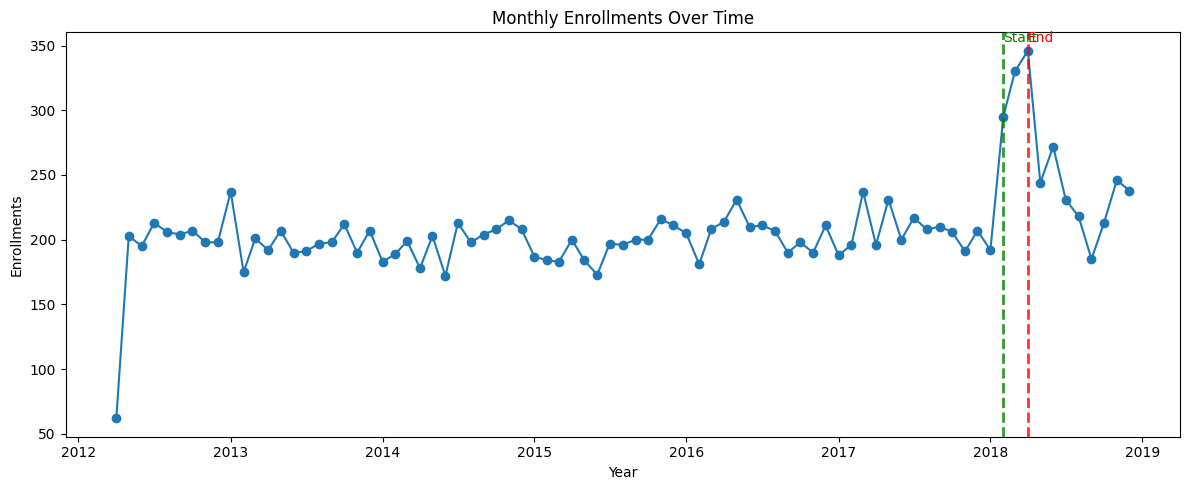

In [67]:

# Ensure dates are timestamps
Enrollment_timeline['Enroll_YearMonth'] = Enrollment_timeline['Enroll_YearMonth'].dt.to_timestamp()

plt.figure(figsize=(12,5))
plt.plot(Enrollment_timeline['Enroll_YearMonth'], Enrollment_timeline['Enrollments'], marker='o')

plt.title("Monthly Enrollments Over Time")
plt.xlabel("Year")
plt.ylabel("Enrollments")

# --- X AXIS: SHOW ONLY YEARS ---
plt.gca().xaxis.set_major_locator(mdates.YearLocator())              # one tick per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))      # format = YYYY

plt.xticks(rotation=0)  # keep horizontal since there are few ticks

# --- ADD PROMOTION MARKERS ---
promo_start = pd.to_datetime('2018-02-01')
promo_end   = pd.to_datetime('2018-04-01')

# Vertical dashed lines
plt.axvline(promo_start, color='green', linestyle='--', linewidth=2, alpha=0.8)
plt.axvline(promo_end, color='red', linestyle='--', linewidth=2, alpha=0.8)

# Position annotations slightly above max value
y_top = Enrollment_timeline['Enrollments'].max() * 1.02

plt.text(promo_start, y_top, 
         'Start', color='green', ha='left')

plt.text(promo_end, y_top,
         'End', color='red', ha='left')

plt.tight_layout()
plt.show()


###### We can see a skpie in enrollments in the promotion time period

### Effect of Promotion on Average Monthly Flights

In [68]:
promo_behavior = (
    Merged_df.groupby('Enrollment Type')['Total Flights']
    .mean()
    .reset_index(name='Avg_Monthly_Flights').round(2)
)

promo_behavior


,Enrollment Type,Avg_Monthly_Flights
0,2018 Promotion,4.20
1,Standard,1.22


###### Customers who enrolled during 2018 promotion flew 3.4 times more than other customers

### Effect of Promotion on Canellations

#### Promotion Vs. Standard Cancellation Rate

In [69]:
History_df_Clean['Cancelled'] = History_df_Clean['Cancellation Date'].notna()

Cancellation_Rate = (
    History_df_Clean.groupby('Enrollment Type')['Cancelled']
    .mean().mul(100).round(2)
    .reset_index(name='Cancellation Rate %')
)

Cancellation_Rate






,Enrollment Type,Cancellation Rate %
0,2018 Promotion,11.84
1,Standard,12.38


###### no significant difference between 2018 enrollments and others

### Multi-Year Timeline Flights Trend

#### Total Flights

In [70]:
Monthly_Flights = (
    Activity_df_Clean.groupby('Date')['Total Flights']
    .sum()
    .reset_index(name='Total_Flights')
    .sort_values('Total_Flights',ascending = False).head(10)
)

Monthly_Flights


,Date,Total_Flights
18,2018-07-01,37811
17,2018-06-01,33743
19,2018-08-01,32690
23,2018-12-01,28746
16,2018-05-01,27256
6,2017-07-01,26212
5,2017-06-01,23422
7,2017-08-01,22902
20,2018-09-01,21955
11,2017-12-01,21797


#### Average Monthly Distance

In [71]:
Monthly_Distance = (
    Activity_df_Clean.groupby('Date')['Distance']
    .mean().round(2)
    .reset_index(name='Avg_Distance')
    .sort_values('Avg_Distance',ascending = False).head(10)
)

Monthly_Distance

,Date,Avg_Distance
18,2018-07-01,3416.38
17,2018-06-01,3009.87
19,2018-08-01,2923.26
23,2018-12-01,2585.54
6,2017-07-01,2478.39
16,2018-05-01,2436.65
5,2017-06-01,2240.36
7,2017-08-01,2177.10
11,2017-12-01,2063.81
20,2018-09-01,1983.13


In [72]:
Monthly_Acc_Points = (
    Activity_df_Clean.groupby('Date')['Points Accumulated']
    .mean().round(2)
    .reset_index(name='Avg_Accumulated_Points')
    .sort_values('Avg_Accumulated_Points',ascending = False).head(10)
)

Monthly_Acc_Points

,Date,Avg_Accumulated_Points
18,2018-07-01,3799.22
17,2018-06-01,3365.45
19,2018-08-01,3257.91
23,2018-12-01,2804.04
16,2018-05-01,2712.84
6,2017-07-01,2478.39
5,2017-06-01,2240.36
7,2017-08-01,2177.10
20,2018-09-01,2107.08
11,2017-12-01,2063.81


###### No Difference in trend using flights/distance/points

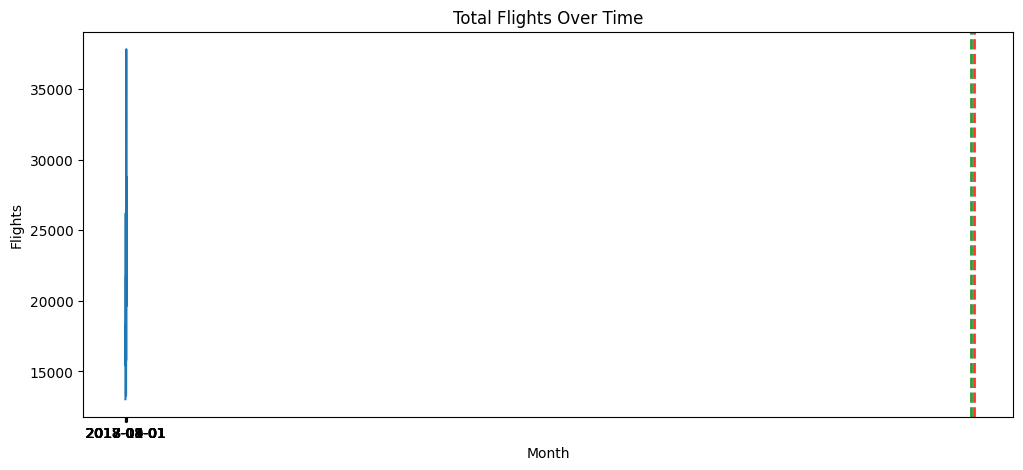

In [73]:
monthly_flights = Activity_df_Clean.groupby('Date')['Total Flights'].sum()

monthly_flights.plot(figsize=(12,5))
# --- ADD PROMOTION MARKERS ---
promo_start = pd.to_datetime('2018-02-01')
promo_end   = pd.to_datetime('2018-04-01')

# Vertical dashed lines
plt.axvline(promo_start, color='green', linestyle='--', linewidth=2, alpha=0.8)
plt.axvline(promo_end, color='red', linestyle='--', linewidth=2, alpha=0.8)



plt.title("Total Flights Over Time")
plt.xlabel("Month")
plt.ylabel("Flights")

plt.show()

###### It is interesting to see that the spike starts after the promotion ended

### CLV Comparison Function

In [74]:
def clv_driver_category(df, category_col):
    """
    Compares CLV across categories.
    df: your History_df_Clean
    category_col: string, column name to compare
    """
    table = (
        df.groupby(category_col)['CLV']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .round(2)
        .reset_index()
    )
    return table


In [75]:
def clv_driver_category(category_col):
    """
    Compare CLV across categories in Merged_df.
    category_col: column name (string)
    """
    table = (
        Merged_df.groupby(category_col)['CLV']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .sort_values('mean',ascending = False)
        .round(2)
        .reset_index()
    )
    return table

In [76]:
clv_driver_category('City')

,City,count,mean,median,min,max
0,Whistler,13591,8775.06,6685.07,2004.35,66025.75
1,Thunder Bay,5962,8507.87,5711.96,2114.74,43019.01
2,Kelowna,1917,8453.68,6005.21,2179.43,46611.87
3,Montreal,47622,8321.34,5979.72,1898.01,83325.38
4,Sudbury,5214,8297.85,5838.90,2178.52,61134.68
5,Victoria,8920,8212.78,6521.37,2132.77,44468.02
6,Fredericton,9914,8126.33,5586.97,2141.98,73225.96
7,Hull,8243,8108.13,6005.85,2127.92,60556.19
8,Winnipeg,15532,8056.19,5638.26,1898.01,83325.38
9,Regina,9504,8038.38,5639.94,2154.07,67907.27


###### No significant difference between promotion/standard

In [77]:
def plot_clv_category(result_table, category_col):
    """
    Plots mean CLV for each category in result_table.
    result_table: output of clv_driver_category()
    category_col: the categorical column being compared
    """
    plt.figure(figsize=(10,5))
    plt.bar(result_table[category_col].astype(str), result_table['mean'], color='skyblue')

    # Add labels and styling
    plt.title(f"Mean CLV by {category_col}")
    plt.xlabel(category_col)
    plt.ylabel("Mean CLV")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


### Distance per Flight Ratio

In [78]:
customer_summary = (
    Activity_df_Clean.groupby('Loyalty Number')
    .agg(
        Total_Flights=('Total Flights', 'sum'),
        Total_Distance=('Distance', 'sum')
    )
    .reset_index()
)


customer_summary['Avg_Distance_Per_Flight'] = (
    customer_summary['Total_Distance'] / customer_summary['Total_Flights']
)

customer_summary = customer_summary.merge(
    History_df_Clean[['Loyalty Number', 'Enrollment Type']],
    on='Loyalty Number',
    how='left'
)

distance_by_enrollment = (
    customer_summary.groupby('Enrollment Type')['Avg_Distance_Per_Flight']
    .agg(['count', 'mean', 'median', 'min', 'max'])
    .round(2)
    .reset_index()
)

distance_by_enrollment




,Enrollment Type,count,mean,median,min,max
0,2018 Promotion,924,1505.78,1511.93,637.43,2489.0
1,Standard,14242,1502.04,1499.50,511.00,2496.0
